# 프로젝트 - 작사가 만들기

### 평가항목

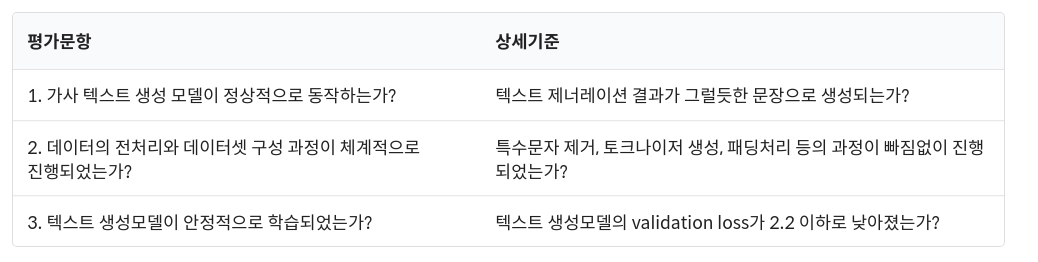

#### 텍스트 제너리이션 결과가 그럴듯한 문장으로 생성되는가?
나름 꽤 된듯.합니다! 
#### 특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?
 문장생성하는거의 전처리 및 과정을 배워서 좋았습니다. 
#### 텍스트 생성모델의 validation loss가 2.2 이하인가?
 네. validation loss 1.04가 나왔습니다. 


## 1. 데이터 다운로드

아래 링크에서 데이터를 다운받아 봅시다.

- <https://www.kaggle.com/paultimothymooney/poetry/data>

## 2. 데이터 읽어오기

`glob` 모듈을 사용하면 파일을 읽어오는 작업을 하기 용이합니다. `glob`를 활용하여 모든 text 파일을 읽어온 후, `raw_corpus` 리스트에 문장 단위로 저장합시다.

In [6]:
import glob
import os

txt_file_path = os.path.dirname(os.path.abspath('__file__')) + r'/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터의 크기 : ", len(raw_corpus))
print("Examples : \n", raw_corpus[:3])

데이터의 크기 :  187088
Examples : 
 ['Yesterday, all my troubles seemed so far away', "Now it looks as though they're here to stay", "Oh, I believe in yesterday Suddenly, I'm not half the man I used to be"]


## 3. 데이터 정제

앞서 배운 테크닉들을 활용해 문장 생성에 적합한 모양새로 데이터를 정제하세요!

`preprocess_sentence()` 함수를 만든 것을 기억하시죠? 이를 활용해 데이터를 정제하도록 하겠습니다.

추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거합니다. 문장을 **토큰화 했을 때 토큰의 개수가 15개를 넘어가면 잘라내기를 권합니다.**

In [11]:
import re

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 문장을 모두 소문자로 바꾸고 양쪽 공백을 제거합니다.
    
    # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 바꿉니다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence) # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환
    
    sentence = sentence.strip()
    
    sentence = '<start> ' + sentence + ' <end>' # 문장의 앞뒤로 <start>와 <end>를 넣어줍니다.
    
    return sentence

이 정제함수를 이용해 정제 데이터를 구해봅시다.

In [42]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0:
        continue
    if len(sentence.split()) >= 13:
        continue
    corpus.append(preprocess_sentence(sentence))

corpus[:10]

['<start> yesterday , all my troubles seemed so far away <end>',
 '<start> now it looks as though they re here to stay <end>',
 '<start> there s a shadow hanging over me . <end>',
 '<start> now i need a place to hide away <end>',
 '<start> now i need a place to hide away <end>',
 '<start> oh , i believe in yesterday <end>',
 '<start> speaking words of wisdom , let it be <end>',
 '<start> speaking words of wisdom , let it be <end>',
 '<start> let it be , let it be , let it be , let it be <end>',
 '<start> there will be an answer , let it be <end>']

추가로 지나치게 긴 문장은 과도한 padding을 갖게 하므로 제거해 주었습니다. 

## 4. 평가 데이터셋 분리

이제 훈련 데이터와 평가 데이터를 만들고 이를 분리해보도록 하겠습니다.

#### tokenize() 함수로 데이터를 tensor로 변환하기

In [43]:
import tensorflow as tf

def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words = 12000, # 전체 단어의 개수
        filters = '',
        oov_token = '<unk>' # out of vocabulary, 사전에 없는 단어는 어떤 토큰으로 대체할지를 말합니다.
    )
    tokenizer.fit_on_texts(corpus) # 만들었던 corpus로부터 Tokenizer가 사전을 자동으로 구축합니다.
    
    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus) # tokenizer는 구축한 사전으로부터 corpus를 해석해 tensor로 반환합니다.
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2 861   4 ...   0   0   0]
 [  2  50  11 ...   0   0   0]
 [  2  62  16 ...   0   0   0]
 ...
 [  2 545  20 ...   0   0   0]
 [  2 121  36 ...   0   0   0]
 [  2   5  23 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7f691197c310>


#### 훈련 데이터와 평가 데이터로 나누기

`sklearn`의 `train_test_split()`를 사용해 훈련 데이터와 평가 데이터를 나누어봅시다.

In [44]:
from sklearn.model_selection import train_test_split

src_input = tensor[:, :-1]
tgt_input = tensor[:, 1:]

enc_train, enc_val, dec_train, dec_val = train_test_split(
    src_input, tgt_input,
    random_state=2020,
    test_size = 0.2
)

In [45]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (127100, 32)
Target Train: (127100, 32)


#### 데이터셋 만들기

In [47]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder = True)
train_dataset

<BatchDataset shapes: ((256, 32), (256, 32)), types: (tf.int32, tf.int32)>

In [49]:
test_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder = True)
test_dataset

<BatchDataset shapes: ((256, 32), (256, 32)), types: (tf.int32, tf.int32)>

## 모델 만들기

모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하세요! (Loss는 아래 제시된 Loss 함수를 그대로 사용!)

그리고 멋진 모델이 생성한 가사 한 줄을 제출하시길 바랍니다!

In [50]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words+1, embedding_size, hidden_size)

In [51]:
for src_sample, tgt_sample in train_dataset.take(1):
    break
model(src_sample)

<tf.Tensor: shape=(256, 32, 12001), dtype=float32, numpy=
array([[[ 7.6637974e-05,  1.5599812e-04,  1.3124074e-04, ...,
         -3.1190895e-04,  1.5064520e-04, -3.3318790e-04],
        [ 2.4329090e-04,  1.5494798e-04,  3.1254333e-04, ...,
         -5.7013659e-04,  2.6466674e-04, -5.0529931e-04],
        [ 2.4478821e-04, -8.3107014e-05,  2.1995611e-04, ...,
         -6.1841123e-04,  1.3142187e-04, -6.5193570e-04],
        ...,
        [-7.3184312e-04,  3.3142702e-03, -9.1867003e-04, ...,
         -1.6057574e-03,  1.0038075e-03,  1.5648381e-03],
        [-6.7358831e-04,  3.3559101e-03, -9.9998701e-04, ...,
         -1.5801726e-03,  8.9655840e-04,  1.6852310e-03],
        [-6.2122627e-04,  3.3929434e-03, -1.0694895e-03, ...,
         -1.5605048e-03,  8.0213707e-04,  1.7883484e-03]],

       [[ 7.6637974e-05,  1.5599812e-04,  1.3124074e-04, ...,
         -3.1190895e-04,  1.5064520e-04, -3.3318790e-04],
        [-2.7697690e-05,  3.7741594e-04,  2.9193636e-04, ...,
         -2.7541068e-04, 

In [52]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [55]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
model.fit(train_dataset, validation_data = test_dataset, epochs=10)

Epoch 1/10
496/496 [==============================] - 139s 280ms/step - loss: 1.3875 - val_loss: 1.3135
Epoch 2/10
496/496 [==============================] - 139s 281ms/step - loss: 1.2516 - val_loss: 1.2363
Epoch 3/10
496/496 [==============================] - 143s 289ms/step - loss: 1.1631 - val_loss: 1.1850
Epoch 4/10
496/496 [==============================] - 149s 301ms/step - loss: 1.0828 - val_loss: 1.1477
Epoch 5/10
496/496 [==============================] - 147s 297ms/step - loss: 1.0118 - val_loss: 1.1173
Epoch 6/10
496/496 [==============================] - 148s 298ms/step - loss: 0.9479 - val_loss: 1.0941
Epoch 7/10
496/496 [==============================] - 160s 323ms/step - loss: 0.8898 - val_loss: 1.0769
Epoch 8/10
496/496 [==============================] - 180s 363ms/step - loss: 0.8371 - val_loss: 1.0629
Epoch 9/10
496/496 [==============================] - 180s 364ms/step - loss: 0.7885 - val_loss: 1.0521
Epoch 10/10
496/496 [==============================] - 160s 323m

긴 시간이 지났습니다!

val_loss는 1.04로 꽤 좋은 숫자를 보이고 있네요. 그럼 한번 작사를 시켜봅시다.

In [56]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]
    
    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다.
    while True:
        predict = model(test_tensor) # 입력받은 문장의 텐서를 입력합니다.
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다.
        
        # 우리 모델이 새롭계 예측한 단어를 입력 문장의 뒤에 붙여줍니다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        
        # 우리 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면 while 루프를 돌면서 다음 단어를 예측해야합니다.
        if predict_word.numpy()[0] == end_token:
            break
        if test_tensor.shape[1] >= max_len:
            break
    
    generated = ""
    
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다.
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "
    
    return generated # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [57]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i love you <end> '

똑같은 문장을 반복하게 되어서 먼가 어색하네요~ 다시 한번 해볼게요!

In [58]:
generate_text(model, tokenizer, init_sentence="<start> if you", max_len=20)

'<start> if you re ready <end> '

In [59]:
generate_text(model, tokenizer, init_sentence="<start> i wonder", max_len=20)

'<start> i wonder if i could be your spouse <end> '

In [60]:
generate_text(model, tokenizer, init_sentence="<start> i wanted", max_len=20)

'<start> i wanted to be your con man with a six story <end> '

In [61]:
generate_text(model, tokenizer, init_sentence="<start> she loves", max_len=20)

'<start> she loves me <end> '

In [64]:
generate_text(model, tokenizer, init_sentence="<start> please give ", max_len=20)

'<start> please give me the <unk> of the night <end> '

In [65]:
generate_text(model, tokenizer, init_sentence="<start> if you want ", max_len=20)

'<start> if you want me , you ll call me <end> '

In [66]:
generate_text(model, tokenizer, init_sentence="<start> say ", max_len=20)

'<start> say it all , <end> '

## Conclusion

생각보다 꽤 그럴싸하게 나와서 신기했습니다. 이게 참..전처리나 그런건 어렵지만, 모델이 학습하고 나올 때의 쾌감이 짜릿합니다! :)


### 다음에 이 노드를 하게된다면?
 1. 전처리를 조금 더 신경 써본다.
 2. 다른 모델을 사용해 본다.
 3. 옵션의 기능들을 좀 더 세심하게 보고자 합니다!


그래도 무사히 끝내서.. 다행입니다! 